In [1]:
"""
Figure 4: Closed-loop gliotransmission (left panel)
Extracellular neurotransmitter concentration (averaged across 500 synapses) for three
step increases of the presynaptic rate, for three synapses: one without gliotransmission,
and the other two with open- and close-loop gliotransmssion.
"""
%reset
# y
import pandas as pd
import numpy as np
from brian2 import *
%matplotlib inline

set_device('cpp_standalone', directory=None)  # Use fast "C++ standalone mode"
seed(16283)  # to get identical figures for repeated runs

################################################################################
# Model parameters
################################################################################
### General parameters
N_synapses = 500
N_astro = 2
duration = 20*second         # Total simulation time
sim_dt = 1*ms                # Integrator/sampling step

### Neuron parameters

# ### Synapse parameters
### Synapse parameters
rho_c = 0.005                # Synaptic vesicle-to-extracellular space volume ratio
Y_T = 500*mmolar             # Total vesicular neurotransmitter concentration
Omega_c = 40/second          # Neurotransmitter clearance rate
U_0__star = 0.6              # Resting synaptic release probability
Omega_f = 3.33/second        # Synaptic facilitation rate
Omega_d = 2.0/second         # Synaptic depression rate
# --- Presynaptic receptors
O_G = 1.5/umolar/second      # Agonist binding (activating) rate
Omega_G = 0.5/(60*second)    # Agonist release (deactivating) rate

### Astrocyte parameters
# ---  Calcium fluxes
O_P = 0.9*umolar/second      # Maximal Ca^2+ uptake rate by SERCAs
K_P = 0.05 * umolar          # Ca2+ affinity of SERCAs
C_T = 2*umolar               # Total cell free Ca^2+ content
rho_A = 0.18                 # ER-to-cytoplasm volume ratio
Omega_C = 6/second           # Maximal rate of Ca^2+ release by IP_3Rs
Omega_L = 0.1/second         # Maximal rate of Ca^2+ leak from the ER
# --- IP_3R kinectics
d_1 = 0.13*umolar            # IP_3 binding affinity
d_2 = 1.05*umolar            # Ca^2+ inactivation dissociation constant
O_2 = 0.2/umolar/second      # IP_3R binding rate for Ca^2+ inhibition
d_3 = 0.9434*umolar          # IP_3 dissociation constant
d_5 = 0.08*umolar            # Ca^2+ activation dissociation constant
# --- IP_3 production
# --- Agonist-dependent IP_3 production
O_beta = 3.2*umolar/second   # Maximal rate of IP_3 production by PLCbeta
O_N = 0.3/umolar/second      # Agonist binding rate
Omega_N = 0.5/second         # Maximal inactivation rate
K_KC = 0.5*umolar            # Ca^2+ affinity of PKC
zeta = 10                    # Maximal reduction of receptor affinity by PKC
# --- Endogenous IP3 production
O_delta = 0.6*umolar/second  # Maximal rate of IP_3 production by PLCdelta
kappa_delta = 1.5* umolar    # Inhibition constant of PLC_delta by IP_3
K_delta = 0.1*umolar         # Ca^2+ affinity of PLCdelta
# --- IP_3 diffusion
F = 2*umolar/second          # GJC IP_3 permeability
I_Theta = 0.3*umolar         # Threshold gradient for IP_3 diffusion
omega_I = 0.05*umolar        # Scaling factor of diffusion
# --- IP_3 degradation
Omega_5P = 0.05/second       # Maximal rate of IP_3 degradation by IP-5P
K_D = 0.7*umolar             # Ca^2+ affinity of IP3-3K
K_3K = 1.0*umolar            # IP_3 affinity of IP_3-3K
O_3K = 4.5*umolar/second     # Maximal rate of IP_3 degradation by IP_3-3K
# --- IP_3 diffusion
F_ex = 2.0*umolar/second     # Maximal exogenous IP3 flow
I_Theta = 0.3*umolar         # Threshold gradient for IP_3 diffusion
omega_I = 0.05*umolar        # Scaling factor of diffusion
# --- Gliotransmitter release and time course
C_Theta = 0.5*umolar         # Ca^2+ threshold for exocytosis
Omega_A = 0.6/second         # Gliotransmitter recycling rate
U_A = 0.6                    # Gliotransmitter release probability
G_T = 200*mmolar             # Total vesicular gliotransmitter concentration
rho_e = 6.5e-4               # Astrocytic vesicle-to-extracellular volume ratio
Omega_e = 60/second          # Gliotransmitter clearance rate
alpha = 0.0                  # Gliotransmission nature

################################################################################
# Model definition
################################################################################
defaultclock.dt = sim_dt  # Set the integration time

# ### "Neurons"
# INCLUDE BEGIN
rate_in = TimedArray([0.011, 0.11, 1.1, 11] * Hz, dt=5*second)
source_neurons = PoissonGroup(N_synapses, rates='rate_in(t)')
target_neurons = NeuronGroup(N_synapses, '')
# INCLUDE END

### Synapses
# Note that the synapse does not actually have any effect on the post-synaptic
# target
# Also note that for easier plotting we do not use the "event-driven" flag here,
# even though the value of u_S and x_S only needs to be updated on the arrival
# of a spike
synapses_eqs = '''
# Neurotransmitter
dY_S/dt = -Omega_c * Y_S : mmolar (clock-driven)
# Fraction of activated presynaptic receptors
dGamma_S/dt = O_G * G_A * (1 - Gamma_S) - Omega_G * Gamma_S : 1 (clock-driven)
# Usage of releasable neurotransmitter per single action potential:
du_S/dt = -Omega_f * u_S : 1 (event-driven)
# Fraction of synaptic neurotransmitter resources available for release:
dx_S/dt = Omega_d *(1 - x_S) : 1 (event-driven)
r_S : 1  # released synaptic neurotransmitter resources
G_A : mmolar  # gliotransmitter concentration in the extracellular space
'''
synapses_action = '''
U_0 = (1 - Gamma_S) * U_0__star + alpha * Gamma_S
u_S += U_0 * (1 - u_S)
r_S = u_S * x_S
x_S -= r_S
Y_S += rho_c * Y_T * r_S
'''
synapses = Synapses(source_neurons, target_neurons,
                    model=synapses_eqs, on_pre=synapses_action,
                    method='linear')
# We create three synapses per connection: only the first two are modulated by
# the astrocyte however. Note that we could also create three synapses per
# connection with a single connect call by using connect(j='i', n=3), but this
# would create synapses arranged differently (synapses connection pairs
# (0, 0), (0, 0), (0, 0), (1, 1), (1, 1), (1, 1), ..., instead of
# connections (0, 0), (1, 1), ..., (0, 0), (1, 1), ..., (0, 0), (1, 1), ...)
# making the later connection descriptions more complicated.
synapses.connect(j='i')  # closed-loop modulation
synapses.connect(j='i')  # open modulation
synapses.connect(j='i')  # no modulation
synapses.x_S = 1.0

### Astrocytes
# The astrocyte emits gliotransmitter when its Ca^2+ concentration crosses
# a threshold
astro_eqs = '''
# Fraction of activated astrocyte receptors:
dGamma_A/dt = O_N * Y_S * (1 - Gamma_A) -
              Omega_N*(1 + zeta * C/(C + K_KC)) * Gamma_A : 1
# IP_3 dynamics:
dI/dt = J_beta + J_delta - J_3K - J_5P + J_ex             : mmolar
J_beta = O_beta * Gamma_A                                 : mmolar/second
J_delta = O_delta/(1 + I/kappa_delta) *
                         C**2/(C**2 + K_delta**2)         : mmolar/second
J_3K = O_3K * C**4/(C**4 + K_D**4) * I/(I + K_3K)         : mmolar/second
J_5P = Omega_5P*I                                         : mmolar/second
delta_I_bias = I - I_bias : mmolar
J_ex = -F_ex/2*(1 + tanh((abs(delta_I_bias) - I_Theta)/omega_I)) *
                sign(delta_I_bias)                        : mmolar/second
I_bias                                                    : mmolar (constant)
# Ca^2+-induced Ca^2+ release:
dC/dt = (Omega_C * m_inf**3 * h**3 + Omega_L) * (C_T - (1 + rho_A)*C) -
        O_P * C**2/(C**2 + K_P**2) : mmolar
dh/dt = (h_inf - h)/tau_h          : 1  # IP3R de-inactivation probability
m_inf = I/(I + d_1) * C/(C + d_5)  : 1
h_inf = Q_2/(Q_2 + C)              : 1
tau_h = 1/(O_2 * (Q_2 + C))        : second
Q_2 = d_2 * (I + d_1)/(I + d_3)    : mmolar
# Fraction of gliotransmitter resources available for release
dx_A/dt = Omega_A * (1 - x_A) : 1
# gliotransmitter concentration in the extracellular space
dG_A/dt = -Omega_e*G_A        : mmolar
# Neurotransmitter concentration in the extracellular space
Y_S                           : mmolar
'''
glio_release = '''
G_A += rho_e * G_T * U_A * x_A
x_A -= U_A *  x_A
'''
astrocyte = NeuronGroup(N_astro*N_synapses, astro_eqs,
                        # The following formulation makes sure that a "spike" is
                        # only triggered at the first threshold crossing
                        threshold='C>C_Theta',
                        refractory='C>C_Theta',
                        # The gliotransmitter release happens when the threshold
                        # is crossed, in Brian terms it can therefore be
                        # considered a "reset"
                        reset=glio_release,
                        method='rk4')
astrocyte.h = 0.9
astrocyte.x_A = 1.0
# Only the second group of N_synapses astrocytes are activated by external stimulation
astrocyte.I_bias = (np.r_[np.zeros(N_synapses), np.ones(N_synapses)])*1.0*umolar

## Connections
# INCLUDE BEGIN
ecs_syn_to_astro = Synapses(synapses, astrocyte,
                            'Y_S_post = Y_S_pre : mmolar (summed)')
# Connect the first N_synapses synapses--astrocyte pairs
ecs_syn_to_astro.connect(j='i if i < N_synapses')
ecs_astro_to_syn = Synapses(astrocyte, synapses,
                            'G_A_post = G_A_pre : mmolar (summed)')
# Connect the first N_synapses astrocytes--pairs (closed-loop)
ecs_astro_to_syn.connect(j='i if i < N_synapses')
# Connect the second N_synapses astrocyte--synapses pairs (open-loop)
ecs_astro_to_syn.connect(j='i if i >= N_synapses and i < 2*N_synapses')
# INCLUDE END

################################################################################
# Monitors
################################################################################
syn_mon = StateMonitor(synapses, 'Y_S',
                       record=np.arange(N_synapses*(N_astro+1)), dt=10*ms)

################################################################################
# Simulation run
################################################################################
run(duration, report='text')



Once deleted, variables cannot be recovered. Proceed (y/[n])? y


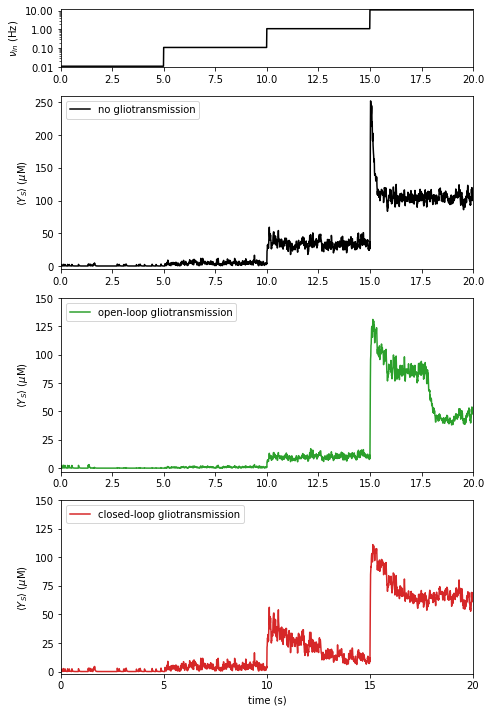

In [4]:
################################################################################
# Analysis and plotting
################################################################################
# plt.style.use('figures.mplstyle')

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8.07, 8.07*1.33),
                       sharex=False,
                       gridspec_kw={'height_ratios': [1, 3, 3, 3],
                                    'top': 0.98, 'bottom': 0.12,
                                    'left': 0.24, 'right': 0.95})
ax[0].semilogy(syn_mon.t/second, rate_in(syn_mon.t), '-', color='black')
ax[0].set(xlim=(0, duration/second), ylim=(0.01, 12),
          yticks=[0.01, 0.1, 1, 10], ylabel=r'$\nu_{in}$ (Hz)')
ax[0].yaxis.set_major_formatter(ScalarFormatter())
# pu.adjust_spines(ax[0], ['left'])

ax[1].plot(syn_mon.t/second,
           np.mean(syn_mon.Y_S[2*N_synapses:]/umolar, axis=0),
           '-', color='black')
ax[1].set(xlim=(0, duration/second), ylim=(-5, 260),
          yticks=np.arange(0, 260, 50),
          ylabel=r'$\langle Y_S \rangle$ ($\mu$M)')
ax[1].legend(['no gliotransmission'], loc='upper left')
# pu.adjust_spines(ax[1], ['left'])

ax[2].plot(syn_mon.t/second,
           np.mean(syn_mon.Y_S[N_synapses:2*N_synapses]/umolar, axis=0),
           '-', color='C2')
ax[2].set(xlim=(0, duration/second), ylim=(-3, 150),
          yticks=np.arange(0, 151, 25),
          ylabel=r'$\langle Y_S \rangle$ ($\mu$M)')
ax[2].legend(['open-loop gliotransmission'], loc='upper left')
# pu.adjust_spines(ax[2], ['left'])

ax[3].plot(syn_mon.t/second,
           np.mean(syn_mon.Y_S[:N_synapses]/umolar, axis=0),
           '-', color='C3')
ax[3].set(xlim=(0, duration/second), ylim=(-2, 150),
          xticks=np.arange(0., duration/second+1, 5.0),
          yticks=np.arange(0, 151, 25),
          xlabel='time (s)', ylabel=r'$\langle Y_S \rangle$ ($\mu$M)')
ax[3].legend(['closed-loop gliotransmission'], loc='upper left')
# pu.adjust_spines(ax[3], ['left', 'bottom'])

# pu.adjust_ylabels(ax, x_offset=-0.22)

# Save Figure for paper # DELETE
# plt.savefig('../text/figures/results/example_4_synrel_Figure.eps', dpi=600)  # DELETE
plt.show()